## Lab 3: SVM

In [19]:
import os
import mne
import numpy as np
from mne import create_info
from mne.io import RawArray
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import moabb
from moabb.datasets import BI2013a
from moabb.paradigms import P300

# Setup
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
moabb.set_log_level("info")

# Configure paths
data_path = "D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data"
os.makedirs(data_path, exist_ok=True)
mne.set_config('MNE_DATA', data_path, set_env=True)
mne.set_config('MNE_DATASETS_BRAININVADERS2013_PATH', data_path, set_env=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(mne.get_config())

Using device: cpu
{'MNE_DATA': 'D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data', 'MNE_DATASETS_BRAININVADERS2013_PATH': 'D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data'}


In [11]:
# Cell 2: Load dataset
print("MNE_DATA =", mne.get_config('MNE_DATA'))
print("MNE_DATASETS_BRAININVADERS2013_PATH =", mne.get_config('MNE_DATASETS_BRAININVADERS2013_PATH'))

m_dataset = BI2013a(NonAdaptive=True, Adaptive=True, Training=True, Online=True)
m_dataset.download()
subjects = m_dataset.subject_list
print(f"Total subjects: {len(subjects)}")

MNE_DATA = D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data
MNE_DATASETS_BRAININVADERS2013_PATH = D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data
Total subjects: 24


In [13]:
def load_data_in_chunks(subjects, paradigm, chunk_size=3):
    """Load data in chunks to manage memory usage."""
    X_chunks, labels_chunks = [], []
    
    for i in range(0, len(subjects), chunk_size):
        chunk_subjects = subjects[i:i + chunk_size]
        X_chunk, labels_chunk = [], []
        
        for subject in chunk_subjects:
            try:
                X_subj, labels_subj, _ = paradigm.get_data(m_dataset, subjects=[subject])
                # Convert to float32 and flatten to save memory
                X_subj = X_subj.astype(np.float32).reshape(X_subj.shape[0], -1)
                X_chunk.append(X_subj)
                labels_chunk.extend(labels_subj)
            except Exception as e:
                print(f"Error loading subject {subject}: {e}")
                continue
                
        if X_chunk:
            X_chunks.append(np.vstack(X_chunk))
            labels_chunks.extend(labels_chunk)
        
        print(f"Processed subjects {i} to {i + len(chunk_subjects) - 1}")
        
        # Clear memory
        del X_chunk, labels_chunk
        
    return np.vstack(X_chunks), np.array(labels_chunks)

# Load and preprocess data
paradigm = P300()

print("Loading data...")
X, labels = load_data_in_chunks(subjects, paradigm)

print("Final dataset shapes:")
print("X shape:", X.shape)
print("Labels shape:", labels.shape)
print("Labels unique values:", np.unique(labels))

label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
y = np.array([label_mapping[label] for label in labels], dtype=np.int32)

print("Label mapping:", label_mapping)

Loading data...
Processed subjects 0 to 2
Processed subjects 3 to 5
Processed subjects 6 to 8
Processed subjects 9 to 11
Processed subjects 12 to 14
Processed subjects 15 to 17
Processed subjects 18 to 20
Processed subjects 21 to 23
Final dataset shapes:
X shape: (104208, 8208)
Labels shape: (104208,)
Labels unique values: ['NonTarget' 'Target']
Label mapping: {'NonTarget': 0, 'Target': 1}


In [14]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, device=None):
        """Initialize SVM with hyperparameters."""
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_losses = []  # Store training losses
        self.val_losses = []  # Store validation losses
        self.best_w = None
        self.best_b = None

    def fit(self, X, y, batch_size=64, class_weights=None, X_val=None, y_val=None, early_stopping_patience=50, verbose=True):
        """Fit SVM using mini-batch SGD with DataLoader and early stopping."""
        X = X.to(self.device)
        y = y.to(self.device)
        n_samples, n_features = X.shape
        
        # Initialize weights and bias
        self.w = torch.zeros(n_features, dtype=torch.float32, device=self.device, requires_grad=False)
        self.b = torch.tensor(0.0, dtype=torch.float32, device=self.device, requires_grad=False)
        
        # Store best weights for early stopping
        self.best_w = self.w.clone()
        self.best_b = self.b.clone()

        # Convert labels to -1, 1 for hinge loss
        y_ = torch.where(y <= 0, -1, 1)
        
        # Prepare sample weights if class weights are provided
        sample_weights = None
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
            sample_weights = torch.zeros_like(y_)
            sample_weights[y == 0] = class_weights[0]
            sample_weights[y == 1] = class_weights[1]

        # Create DataLoader for mini-batch training
        dataset = TensorDataset(X, y_)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Early stopping variables
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.n_iters):
            epoch_loss = 0.0
            num_batches = 0
            
            # Mini-batch training
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                # Forward pass
                linear_pred = torch.matmul(X_batch, self.w) + self.b
                
                # Hinge loss with L2 regularization
                hinge = torch.clamp(1 - y_batch * linear_pred, min=0)
                
                # Apply sample weights if provided
                if sample_weights is not None:
                    batch_indices = torch.arange(len(X_batch), device=self.device)
                    batch_sample_weights = sample_weights[batch_indices + num_batches * batch_size]
                    hinge = hinge * batch_sample_weights
                
                # Calculate loss
                reg = 0.5 * torch.sum(self.w ** 2)
                loss = torch.mean(hinge) + self.lambda_param * reg
                epoch_loss += loss.item()
                num_batches += 1

                # Gradient computation and updates
                with torch.no_grad():
                    mask = (y_batch * linear_pred <= 1).float()
                    
                    if sample_weights is not None:
                        weighted_mask = mask * batch_sample_weights
                        dw_hinge = torch.matmul(X_batch.T, weighted_mask * y_batch) / len(X_batch)
                    else:
                        dw_hinge = torch.matmul(X_batch.T, mask * y_batch) / len(X_batch)
                    
                    # Weight updates
                    dw = self.lr * dw_hinge - self.lr * self.lambda_param * self.w
                    db = self.lr * torch.mean(mask * y_batch) if sample_weights is None else \
                         self.lr * torch.mean(weighted_mask * y_batch)

                    self.w += dw
                    self.b += db

            # Store average epoch loss
            avg_epoch_loss = epoch_loss / num_batches
            self.train_losses.append(avg_epoch_loss)

            # Validation
            if X_val is not None and y_val is not None:
                val_loss = self._compute_validation_loss(X_val, y_val)
                self.val_losses.append(val_loss)
                
                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    # Save best weights
                    self.best_w = self.w.clone()
                    self.best_b = self.b.clone()
                else:
                    patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch}, best val loss: {best_val_loss:.4f}")
                    # Restore best weights
                    self.w = self.best_w
                    self.b = self.best_b
                    break

            # Print progress
            if verbose and (epoch % 100 == 0 or epoch == self.n_iters - 1):
                print(f"Epoch {epoch}, Train Loss: {avg_epoch_loss:.4f}", end="")
                if X_val is not None and y_val is not None:
                    print(f", Val Loss: {val_loss:.4f}")
                else:
                    print()

    def _compute_validation_loss(self, X_val, y_val):
        """Compute validation loss."""
        with torch.no_grad():
            X_val = X_val.to(self.device)
            y_val_ = torch.where(y_val.to(self.device) <= 0, -1, 1)
            
            val_pred = torch.matmul(X_val, self.w) + self.b
            val_hinge = torch.clamp(1 - y_val_ * val_pred, min=0)
            val_loss = torch.mean(val_hinge) + self.lambda_param * 0.5 * torch.sum(self.w ** 2)
            
            return val_loss.item()

    def predict(self, X):
        """Predict class labels (0 or 1)."""
        with torch.no_grad():
            X = X.to(self.device)
            linear_pred = torch.matmul(X, self.w) + self.b
            return torch.where(torch.sign(linear_pred) >= 0, 1, 0)

    def decision_function(self, X):
        """Return decision scores (wx + b) for ROC-AUC."""
        with torch.no_grad():
            X = X.to(self.device)
            return torch.matmul(X, self.w) + self.b

    def plot_training_history(self):
        """Plot training and validation loss history."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss')
        if self.val_losses:
            plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.show()

In [23]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_val_scaled = scaler.transform(X_val).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

print("Data preprocessing completed")
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Unique labels in training: {torch.unique(y_train_tensor)}")

# Compute class weights for imbalanced data
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
print(f"Class weights: {class_weights}")

Data split completed:
Training set: 62524 samples
Validation set: 20842 samples
Test set: 20842 samples
Data preprocessing completed
Training data shape: torch.Size([62524, 8208])
Unique labels in training: tensor([0., 1.])
Class weights: tensor([0.6000, 3.0002])


In [48]:
# Cell 6: Model training with improved setup
# Initialize and train SVM
svm = SVM(
    learning_rate=0.0001, 
    lambda_param=0.5, 
    n_iters=1000, 
    device=device
)

print("Starting training...")
svm.fit(
    X_train_tensor, 
    y_train_tensor,
    batch_size=32,
    class_weights=class_weights,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    early_stopping_patience=50,
    verbose=True
)

print("Training completed!")

Starting training...
Epoch 0, Train Loss: 0.4501, Val Loss: 0.8438
Early stopping at epoch 95, best val loss: 0.3313
Training completed!


Model Evaluation:

Validation Set Evaluation:
Accuracy: 0.8360
ROC-AUC Score: 0.8308

Classification Report:
              precision    recall  f1-score   support

   NonTarget       0.84      1.00      0.91     17368
      Target       0.92      0.02      0.03      3474

    accuracy                           0.84     20842
   macro avg       0.88      0.51      0.47     20842
weighted avg       0.85      0.84      0.76     20842



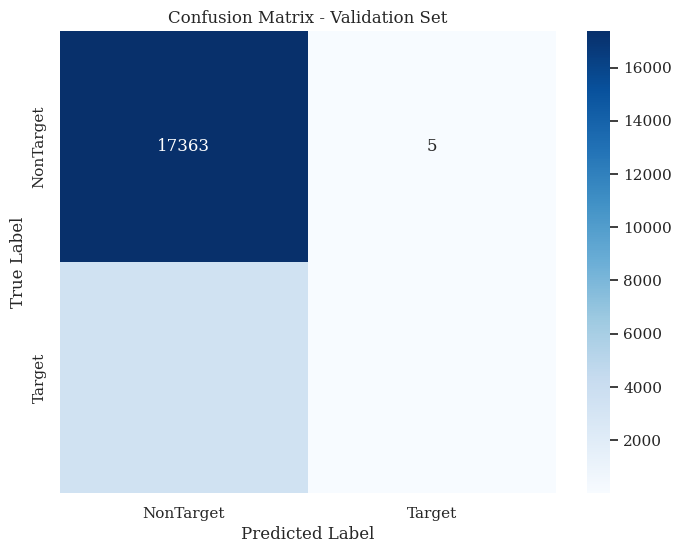


Test Set Evaluation:
Accuracy: 0.8368
ROC-AUC Score: 0.8310

Classification Report:
              precision    recall  f1-score   support

   NonTarget       0.84      1.00      0.91     17368
      Target       0.99      0.02      0.04      3474

    accuracy                           0.84     20842
   macro avg       0.91      0.51      0.48     20842
weighted avg       0.86      0.84      0.77     20842



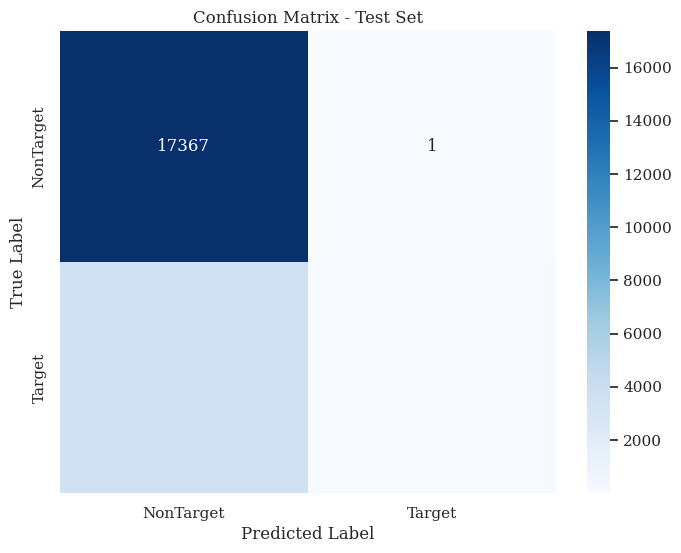

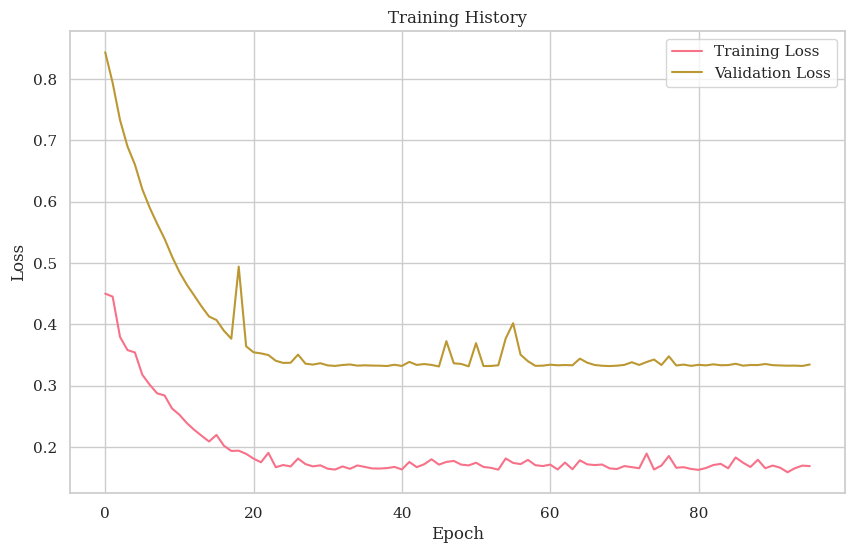

In [49]:
# Cell 7: Comprehensive model evaluation
def evaluate_model(model, X, y, set_name="Validation"):
    """Comprehensive model evaluation."""
    with torch.no_grad():
        # Predictions
        y_pred = model.predict(X)
        y_scores = model.decision_function(X)
        
        # Convert to numpy for scikit-learn metrics
        y_np = y.cpu().numpy() if torch.is_tensor(y) else y
        y_pred_np = y_pred.cpu().numpy()
        y_scores_np = y_scores.cpu().numpy()
        
        # Calculate metrics
        accuracy = accuracy_score(y_np, y_pred_np)
        auc_score = roc_auc_score(y_np, y_scores_np)
        
        print(f"\n{set_name} Set Evaluation:")
        print("=" * 50)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC-AUC Score: {auc_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_np, y_pred_np, target_names=['NonTarget', 'Target']))
        
        # Confusion matrix
        cm = confusion_matrix(y_np, y_pred_np)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['NonTarget', 'Target'],
                   yticklabels=['NonTarget', 'Target'])
        plt.title(f'Confusion Matrix - {set_name} Set')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return accuracy, auc_score

# Evaluate on validation set
print("Model Evaluation:")
val_accuracy, val_auc = evaluate_model(svm, X_val_tensor, y_val_tensor, "Validation")

# Evaluate on test set
test_accuracy, test_auc = evaluate_model(svm, X_test_tensor, y_test_tensor, "Test")

# Plot training history
svm.plot_training_history()

Feature Importance Analysis:


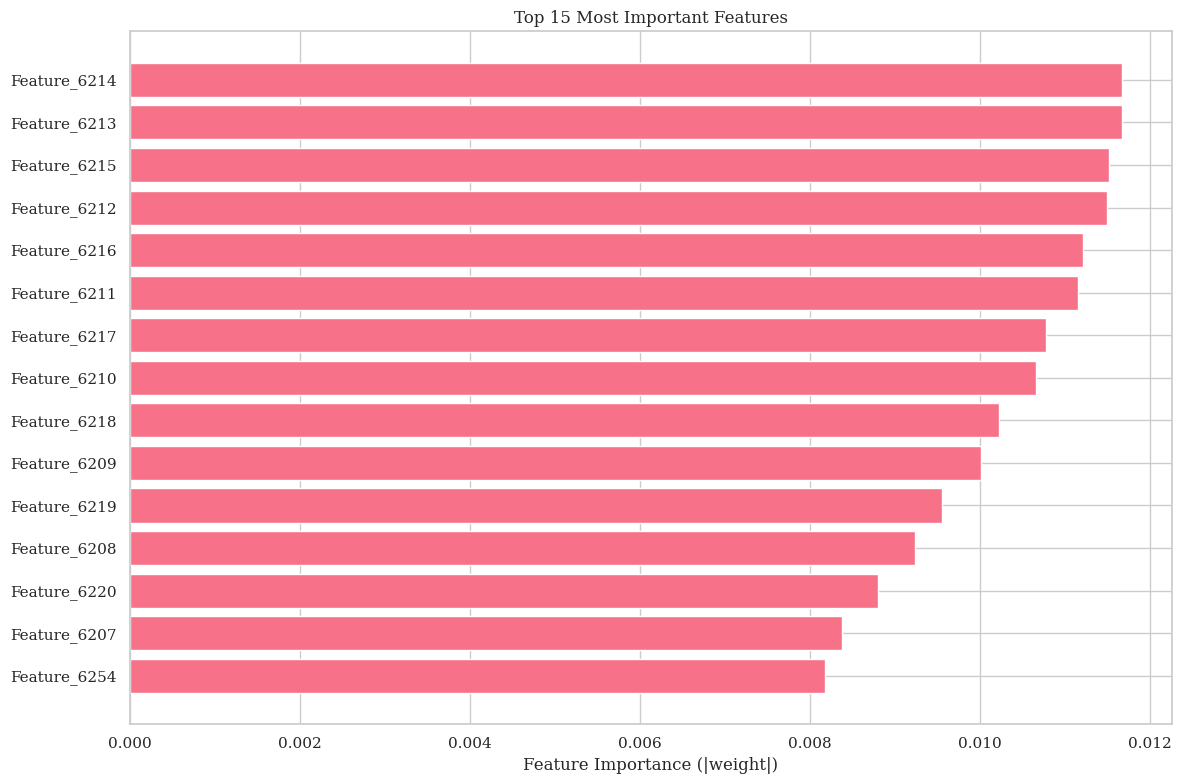


FINAL MODEL SUMMARY
Best validation accuracy: 0.8360
Best validation AUC: 0.8308
Test accuracy: 0.8368
Test AUC: 0.8310
Number of features: 8208
Model weights shape: torch.Size([8208])
Final bias: -1.1046


In [50]:
# Cell 8: Additional analysis and visualization
def plot_feature_importance(model, feature_names=None, top_k=20):
    """Plot top K most important features."""
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(len(model.w))]
    
    # Get absolute weights as importance scores
    importance = torch.abs(model.w).cpu().numpy()
    
    # Get top K features
    top_indices = np.argsort(importance)[-top_k:][::-1]
    top_importance = importance[top_indices]
    top_features = [feature_names[i] for i in top_indices]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_importance)), top_importance[::-1])
    plt.yticks(range(len(top_importance)), top_features[::-1])
    plt.xlabel('Feature Importance (|weight|)')
    plt.title(f'Top {top_k} Most Important Features')
    plt.tight_layout()
    plt.show()

# Plot feature importance (using dummy feature names for EEG data)
print("Feature Importance Analysis:")
plot_feature_importance(svm, top_k=15)

# Print final model summary
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Best validation accuracy: {val_accuracy:.4f}")
print(f"Best validation AUC: {val_auc:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Number of features: {X_train_tensor.shape[1]}")
print(f"Model weights shape: {svm.w.shape}")
print(f"Final bias: {svm.b.item():.4f}")